# Instruction tuning of LLaMA 2

#### What is instruction tuning?

Instruction tuning represents a particular form of fine-tuning where a model is trained on pairs of input-output instructions providing the tuned model the ability to learn specific tasks guided by these instructions.

Providing these input and output pairs trains the model to comprehend and execute tasks based on given instructions. These instructions span a wide array of text types, from composing emails to sentence editing, fostering the model’s adaptability across various instruction-driven tasks. By exposing the model to diverse instructions, it can potentially gain robust generalization skills, enhancing its ability to generate accurate responses aligned with human-like instruction formats.

A good example as a benchmark is the [Stanford Alpaca](https://crfm.stanford.edu/2023/03/13/alpaca.html) model which is a instruction following model trained on an instruction dataset generated in a self-instruct manner. They emphasize that the recipe for this to work well is to have a a strong pretrained language model and high-quality instruction-following data. Their first criterion is satisfied by using Meta's LLaMA 7B model and their second requirement is met by a high quality instruction dataset generated by their self-instruct method.

They started with 175 human-written instruction-output pairs from the self-instruct seed set. These were then used to prompt OpenAI's text-davinci-003 model to generate more instructions using the seed set as in-context examples resulting in 52K unique instructions and the corresponding outputs. Further details on their recipe can be found in their [self-instruct](![alpaca_example.png](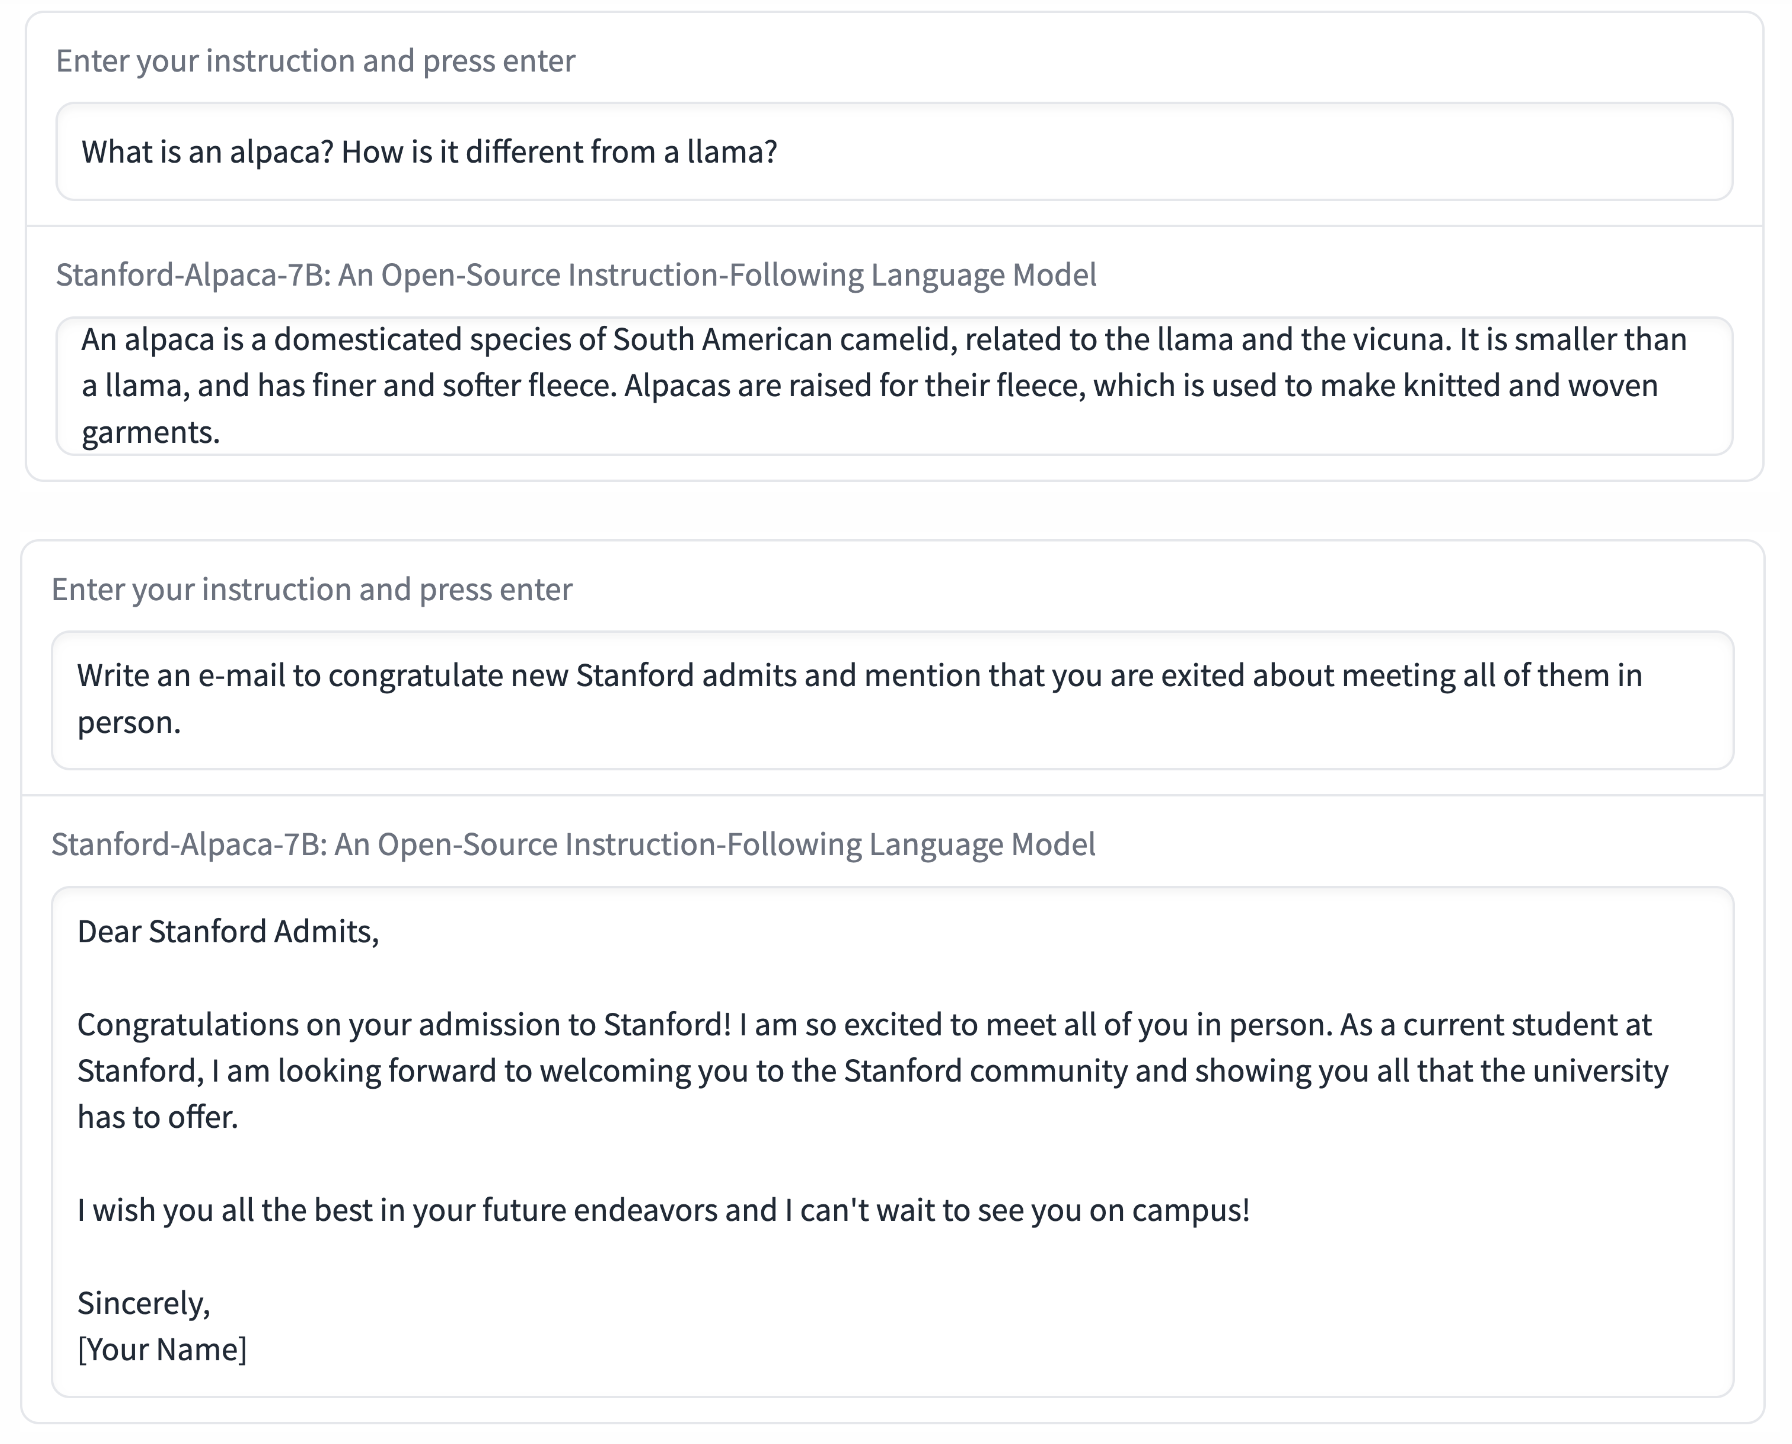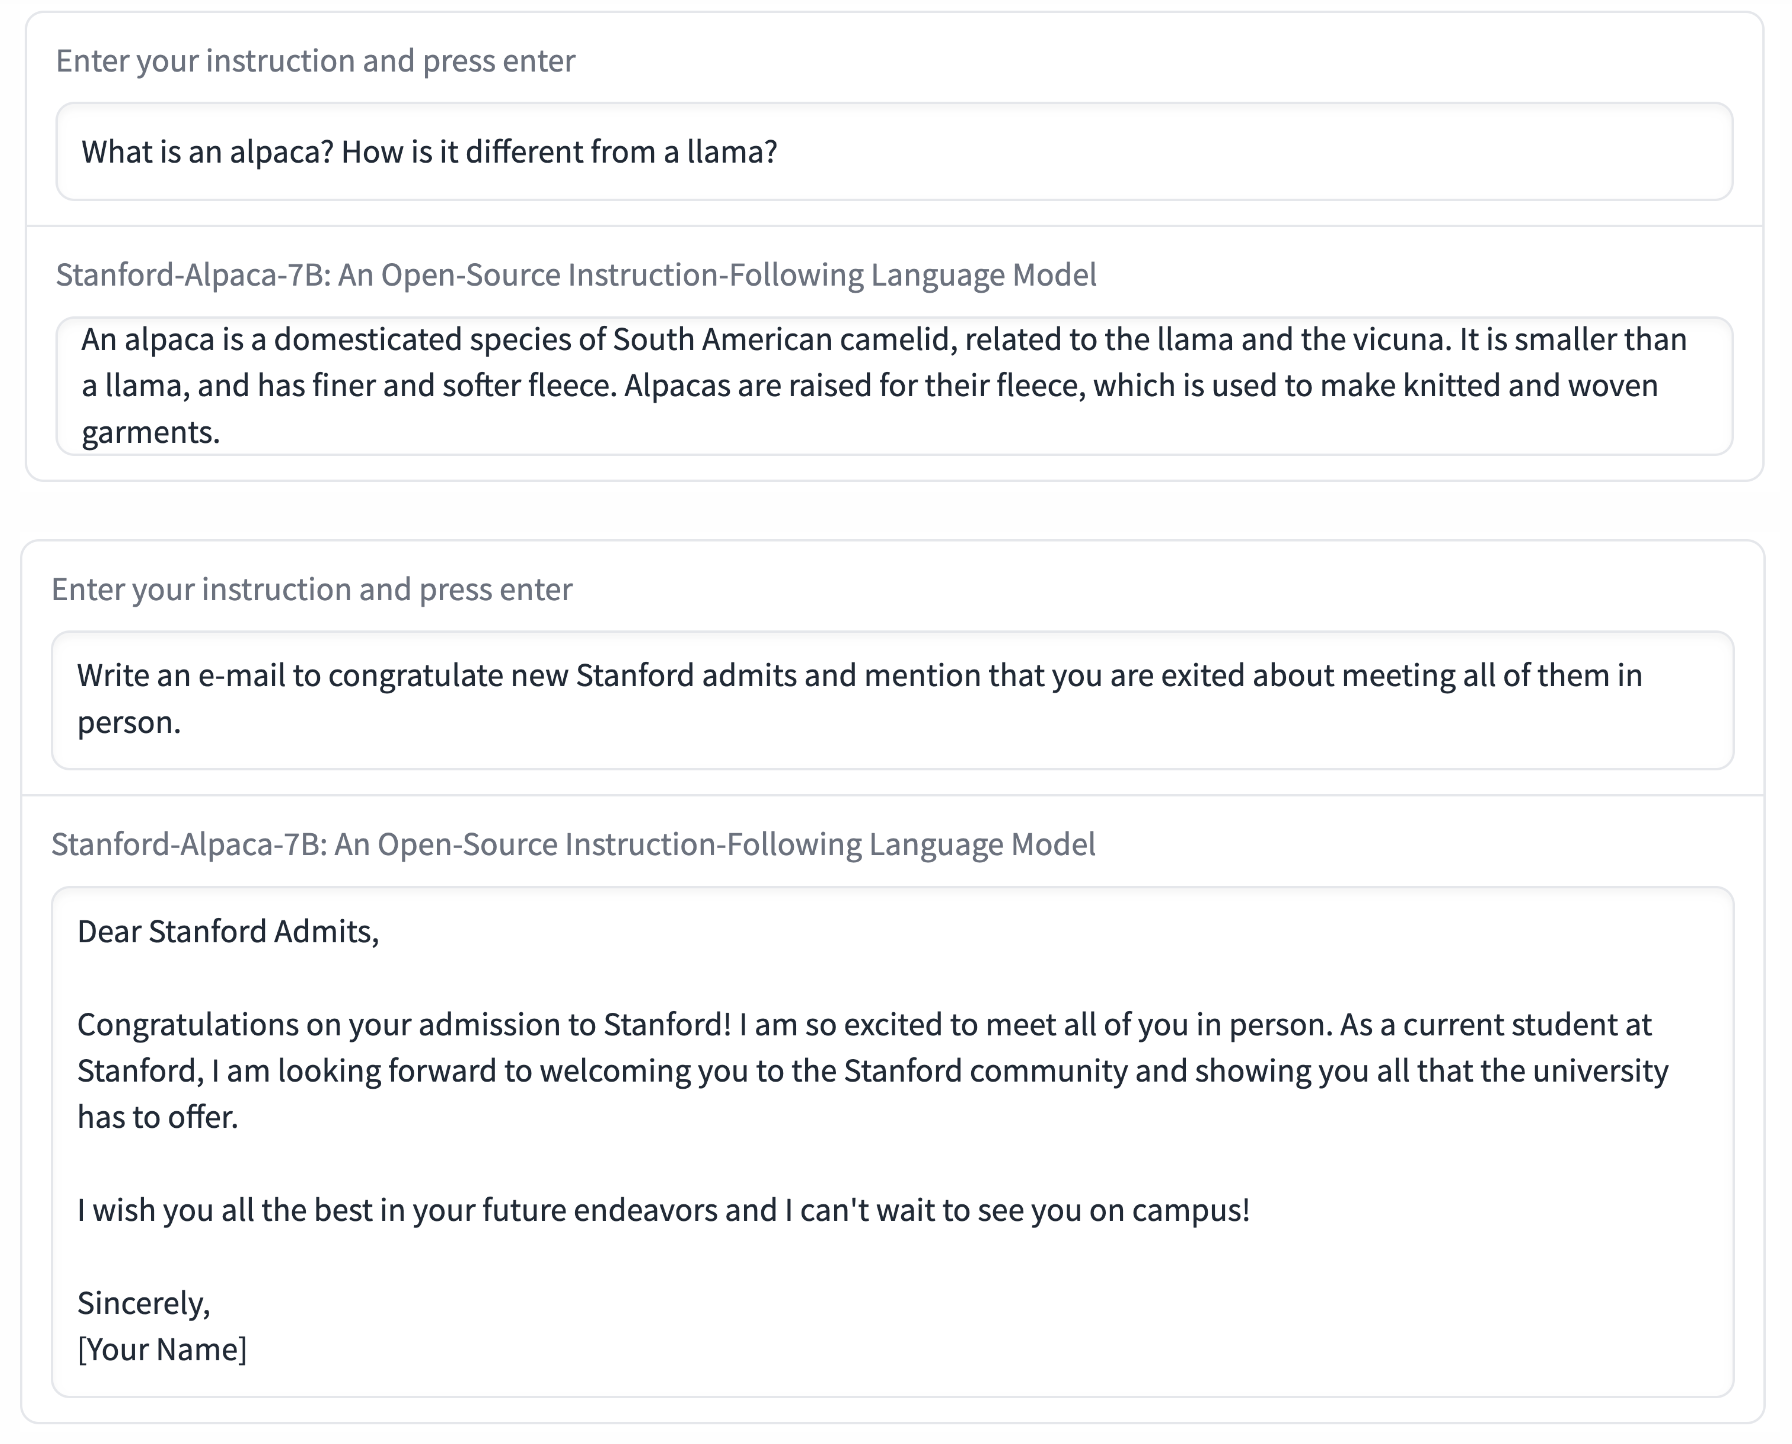)https://arxiv.org/abs/2212.10560://) paper.

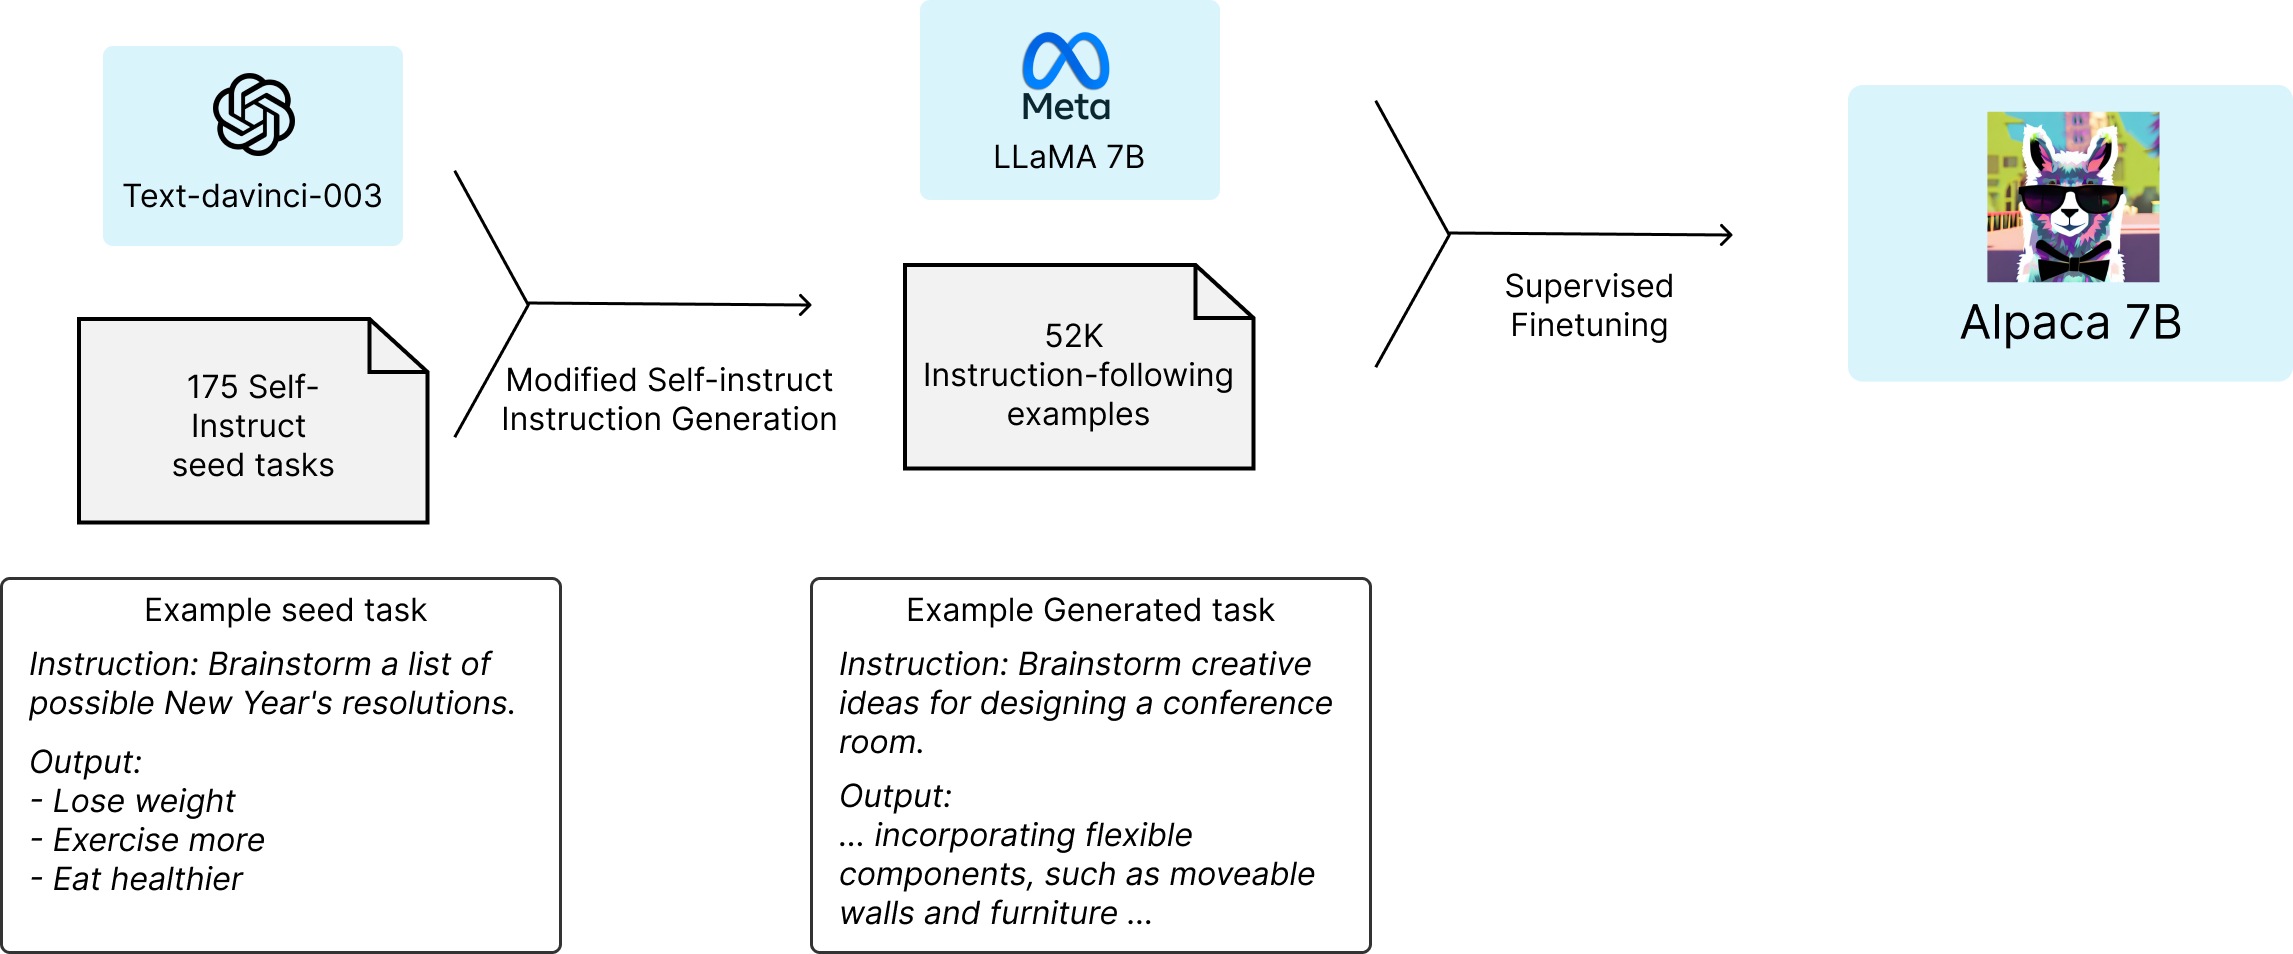




Usual prompt template for a instruction following dataset looks like this -

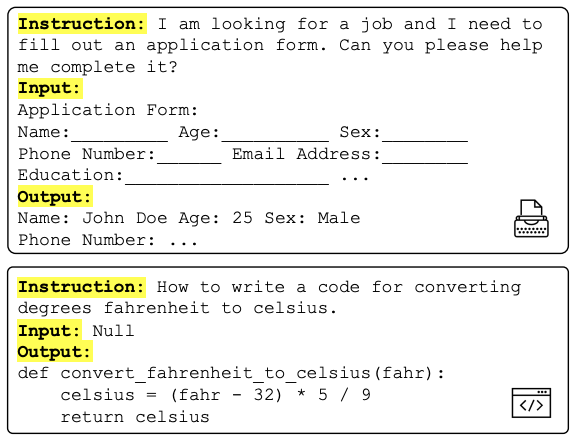

## Parameter-Efficient Fine-tuning (PEFT)

As language models get larger, it becomes impractical to fully fine-tune them on consumer hardware for downstream tasks. Further, since the fully fine-tuned model is the same size as the pretrained model, even storage and depolyment for downstream tasks becomes highly expensive. PEFT approaches are meant to address these challenges. Here is a good article from HF going through the different [PEFT](https://huggingface.co/blog/peft) approaches.

We will go through two popular ones - LoRA and QLoRA.

### What is LoRA?

Low-rank Adaptation (LoRA) essentially works by decomposing the weight changes into a lower rank representation. This [article](https://lightning.ai/pages/community/tutorial/lora-llm/) presents a good summary on the workings of this method. More details can be found in the original paper - [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685).

While the weights of a pretrained model have full rank on the pretrained tasks, according to [Aghajanyan et al. (2020)](https://arxiv.org/abs/2012.13255) which inspired the work on LoRA, the pretrained large language models have a low “intrinsic dimension” when they are adapted to a new task.

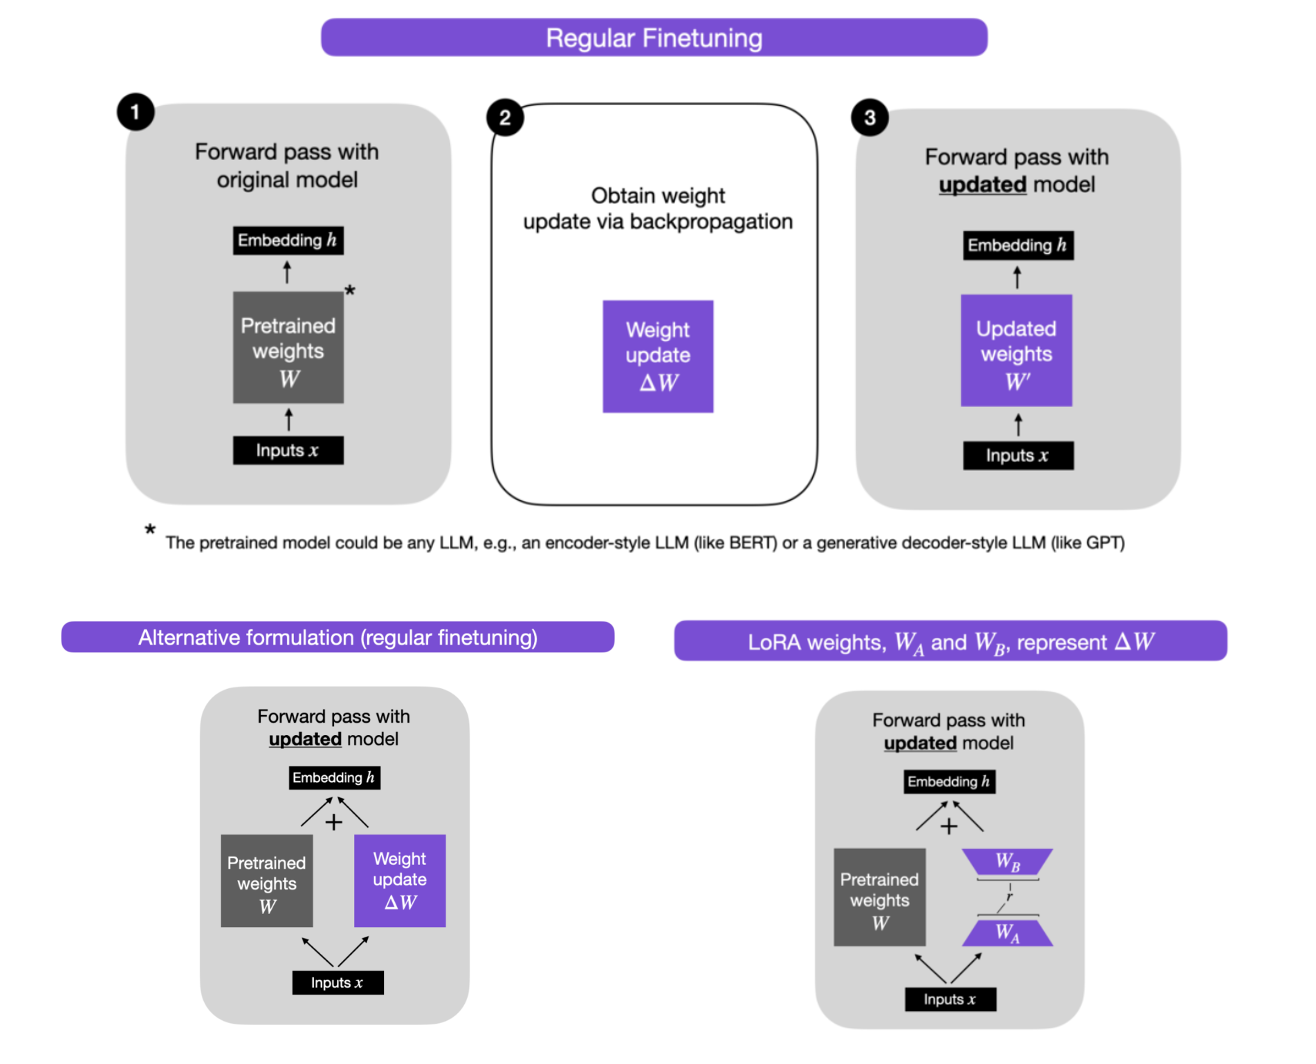

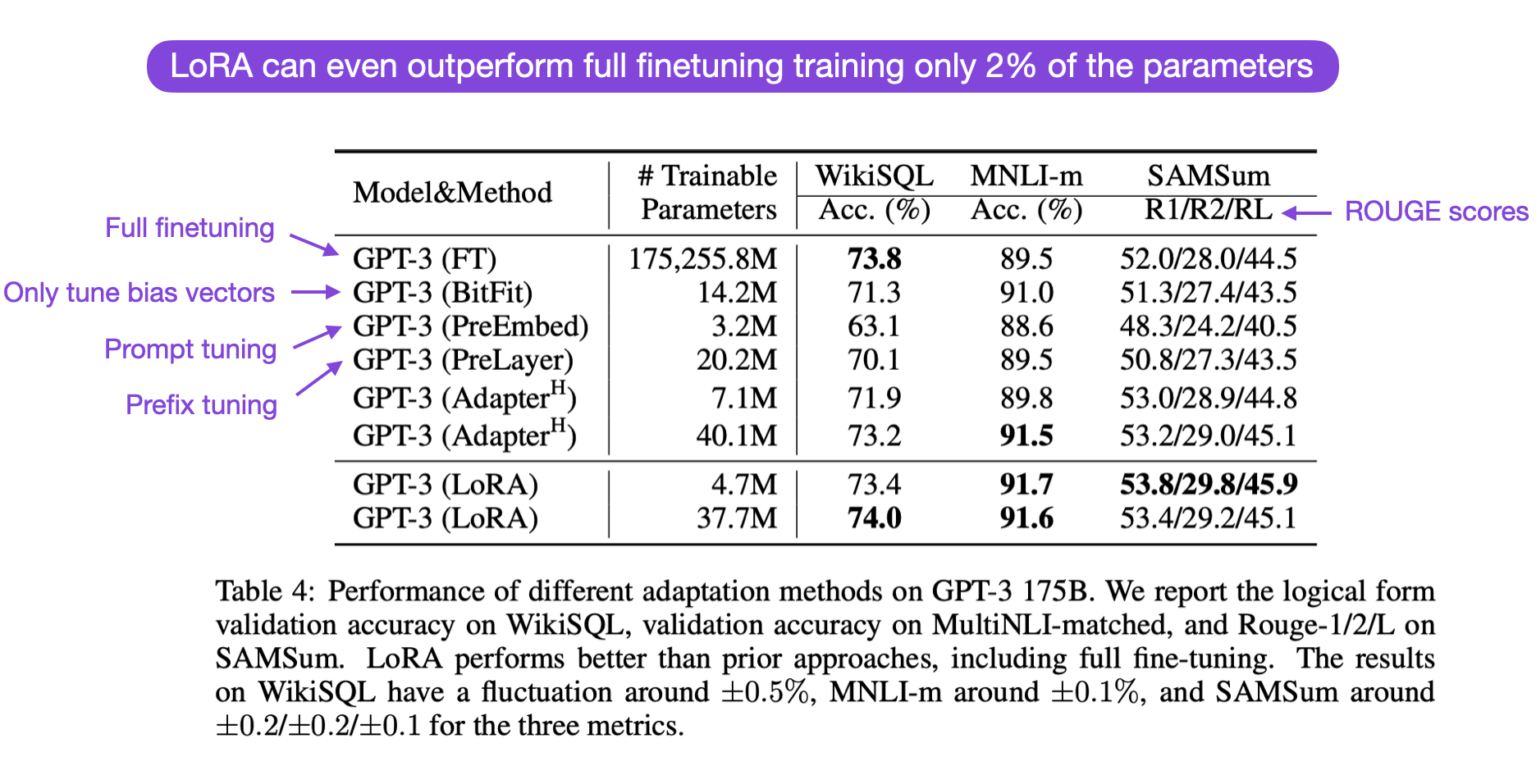

# ΔW = α ( -∇ LW)

### What is QLoRA?


Quantized LoRA (QLoRA) is an extension of LoRA that further introduces quantization to enhance parameter efficiency during fine-tuning. I point to this [article](https://www.analyticsvidhya.com/blog/2023/08/lora-and-qlora/) for an introductory summary. There is also this [talk](https://www.youtube.com/watch?v=y9PHWGOa8HA) by one of the authors of the original paper - [QLORA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2106.09685).

The method introduces 4-bit NormalFloat (NF4) quantization and Double Quantization techniques applied to LoRA.

* NF4 Quantization: NF4 quantization leverages the inherent distribution of pre-trained neural network weights, usually zero-centered normal distributions with specific standard deviations. By transforming all weights to a fixed distribution that fits within the range of NF4 (-1 to 1), NF4 quantization effectively quantifies the weights without the need for expensive quantile estimation algorithms.

* Double Quantization: Double Quantization addresses the memory overhead of quantization constants. Double Quantization significantly reduces the memory footprint without compromising performance by quantizing the quantization constants themselves. The process involves using 8-bit Floats with a block size 256 for the second quantization step, resulting in substantial memory savings.

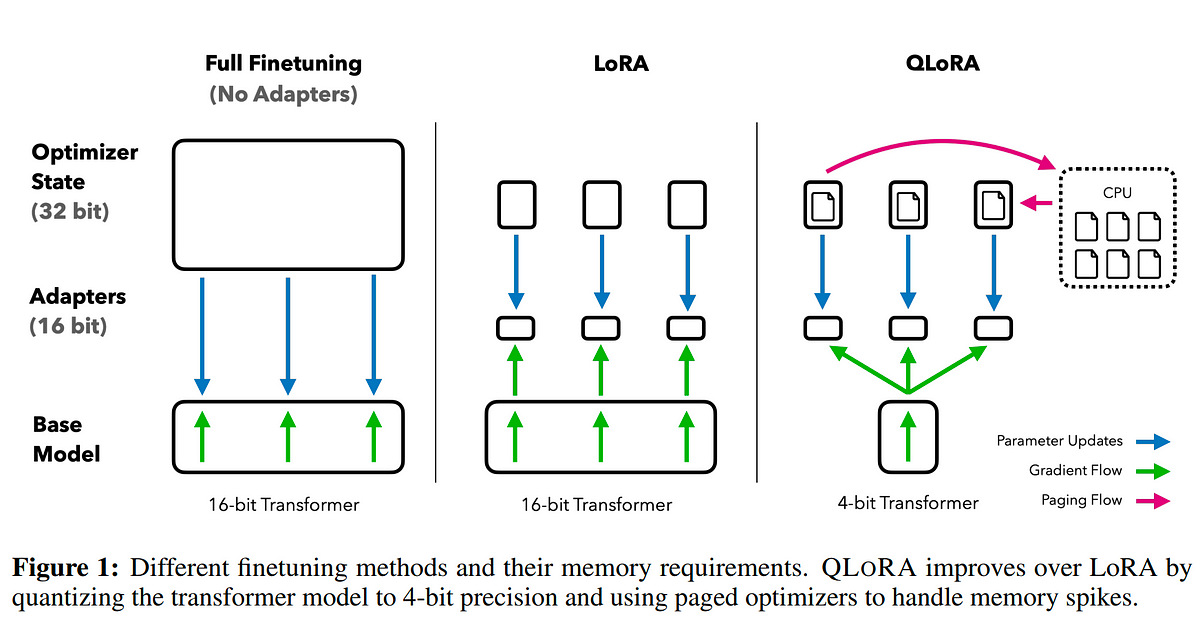

## Instruct tuning in PEFT mode

The training setup in this notebook follows [maximelabonne's](https://mlabonne.github.io/blog/posts/Fine_Tune_Your_Own_Llama_2_Model_in_a_Colab_Notebook.html) notebook fine-tuning Llama2 model using instruction dataset

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [ ]:
# Imports
import os
import torch
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from transformers import HfArgumentParser, TrainingArguments
from transformers import pipeline, logging

In [ ]:
# Performance
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
# Base Llama2 model to be loaded
model_name = "NousResearch/Llama-2-7b-chat-hf"

# Instruction dataset to be used for fine-tuning the base model
dataset_name = "mlabonne/guanaco-llama2-1k"

# Name of model to be pushed to hub post fine-tuning
tuned_model = "llama-2-7b-guanaco-1k"

In [ ]:
# Parameters for quantized training via bitsandbytes

# 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

In [ ]:
# QLoRA - quantized LoRA training parameters

# LoRA rank
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

In [ ]:
# Training arguments

# Output directory to store results
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

In [ ]:
# Supervised fine-tuning (SFT) parameters

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [ ]:
# Load dataset
from datasets import load_dataset
dataset = load_dataset(dataset_name, split="train")

In [ ]:
# Load tokenizer and model with QLoRA configuration

compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [ ]:
# # Check GPU compatibility with bfloat16

# if compute_dtype == torch.float16 and use_4bit:
#     major, _ = torch.cuda.get_device_capability()
#     if major >= 8:
#         print("=" * 80)
#         print("Your GPU supports bfloat16: accelerate training with bf16=True")
#         print("=" * 80)

In [ ]:
# Load base model

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
# Load LLaMA tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
# Load LoRA configuration

peft_config = LoraConfig(
                  lora_alpha=lora_alpha,
                  lora_dropout=lora_dropout,
                  r=lora_r,
                  bias="none",
                  task_type="CAUSAL_LM",
              )

In [ ]:
# Set training arguments

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

In [ ]:
# Set supervised fine-tuning parameters

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

In [ ]:
# Train model
trainer.train()

In [ ]:
# Saving trained model
trainer.model.save_pretrained(tuned_model)

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

### Text generation using the fine-tuned model

In [ ]:
# Set text generation pipeline
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)

In [ ]:
def generate(prompt="", pipe=pipe):
    """ Generate with given prompt """

    result = pipe(f"<s>[INST] {prompt} [/INST]")
    return result[0]['generated_text']

In [ ]:
# Run text generation pipeline with instruct-tuned model
prompt = "What is a large language model?"
generated_text = generate(prompt=prompt)
print(generated_text)

In [ ]:
prompt = "Explain to me pythagoras theorem"
generated_text = generate(prompt=prompt)
print(generated_text)

In [ ]:
prompt = "What is grand unified theory?"
generated_text = generate(prompt=prompt)
print(generated_text)

In [ ]:
prompt = "List Maxwell's equations of electromagnetism"
generated_text = generate(prompt=prompt)
print(generated_text)

In [ ]:
prompt = "What are the system pathways playing a crucial role in lung cancer?"
generated_text = generate(prompt=prompt)
print(generated_text)

In [ ]:
prompt = "What is the difference between NP hard and NP complete?"
generated_text = generate(prompt=prompt)
print(generated_text)

## An example of a simple scientific instruction dataset that you can play with!

#### [SciBench](https://github.com/mandyyyyii/scibench) is a novel benchmark for college-level scientific problems consisting of 695 problems sourced from instructional textbooks. The benchmark is designed to evaluate the complex reasoning capabilities, strong domain knowledge, and advanced calculation skills of LLMs.

Below is the code provided from [Platypus](https://github.com/arielnlee/Platypus/blob/main/data_pipeline/scibench_format.py) repo that has scripts for formatting data in instruct form

In [ ]:
# https://github.com/arielnlee/Platypus/blob/main/data_pipeline/scibench_format.py

import os
import json
import subprocess
import os
# The directory where the json files are stored
# dir_path = 'original'
output_file = 'scibench_formatted.json'

import subprocess


# Define the repository URL
repo_url = "https://github.com/mandyyyyii/scibench.git"
repo_name = "scibench"
target_subdir = "dataset/original"

# Clone the repository
result_clone = subprocess.run(["git", "clone", repo_url])

# Check if the clone command was successful
if result_clone.returncode == 0:
    print("Repository cloned successfully!")

    # Construct the path to the target directory within the cloned repository
    target_path = os.path.join(os.getcwd(), repo_name, target_subdir)
    print("Path to the target directory:", target_path)
else:
    print("An error occurred while cloning the repository.")

json_files = [f for f in os.listdir(target_path) if f.endswith('.json')]


new_data = []

# Iterate over all the files
for json_file in json_files:
    file_path = os.path.join(target_path, json_file)

    # Open each json file
    with open(file_path, 'r') as f:
        # Load the data
        file_data = json.load(f)

        # Transform the data
        for d in file_data:
            output = d.get('solution')
            if not output:
                output = d.get('answer_number')
            transformed_data = {
                "instruction": d.get('problem_text'),
                "input": '',
                "output": output
            }
            new_data.append(transformed_data)

# Save the transformed data to a new json file
with open(output_file, 'w') as f:
    json.dump(new_data, f, indent=1)

# Remove the cloned repository
result_remove = subprocess.run(["rm", "-rf", repo_name])

In [ ]:
new_data[:2]